In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os  
from matplotlib.ticker import PercentFormatter
from scipy.optimize import curve_fit


# plot cpu, gpu power pattern for GPGPU apps
def replace_negative_with_average(data, column_name):
    for i in range(1, len(data) - 1):
        if data.at[i, column_name] < 0:
            previous_value = data.at[i - 1, column_name]
            next_value = data.at[i + 1, column_name]
            data.at[i, column_name] = (previous_value + next_value) / 2

def plot_power_CPU_GPU(cpu_filename, gpu_filename, benchmark):
    # Load the CSV files into DataFrames
    cpu_data = pd.read_csv(cpu_filename)
    gpu_data = pd.read_csv(gpu_filename)

    # Replace negative values with the average of the previous and next values
    replace_negative_with_average(cpu_data, 'Package Power (W)')
    replace_negative_with_average(gpu_data, 'GPU 0 Power (W)')

    # Plot the data
    plt.figure(figsize=(4, 3))
    plt.plot(cpu_data['Time (s)'], cpu_data['Package Power (W)'], label='RAPL Package Power', color='blue')
    plt.plot(gpu_data['Time (s)'], gpu_data['GPU 0 Power (W)'], label='GPU Power', color='red')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (W)')
    plt.title(f'Power Consumption ({benchmark})', pad=40)
    # Position the legend outside the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
    plt.grid(True, axis="y", alpha=0.5)
    
    # Make sure the ./fig directory exists, if not, create it
    # os.makedirs('./fig', exist_ok=True)
    # # Save the figure
    # plt.savefig(f'./fig/power_cpu_gpu_{benchmark}.jpg', bbox_inches='tight')
    plt.show()

def plot_power_CPU(cpu_filename, benchmark):
    # Load the CSV file into a DataFrame
    cpu_data = pd.read_csv(cpu_filename)

    # Filter the data to plot every 1 second (assuming data points every 0.1 seconds)
    filtered_cpu_data = cpu_data.iloc[::1]  # Select every 10th row

    # Plot the data
    plt.figure(figsize=(6, 4))
    plt.plot(filtered_cpu_data['Time (s)'], filtered_cpu_data['Package Power (W)'],
             label='RAPL Package Power', color='blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (W)')
    plt.title(f'Power Consumption ({benchmark})', pad=40)
    
    # Position the legend outside the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
    plt.grid(True, axis="y", alpha=0.5)
    
    # Save the figure in the ./fig directory
    # os.makedirs('./fig', exist_ok=True)
    # plt.savefig(f'./fig/power_cpu_{benchmark}.jpg', bbox_inches='tight')
    
    # Display the plot
    plt.show()




# plot the power capping results for GPGPU apps
def plot_power_cap(file_cpu_cap, file_gpu_cap, benchmark,altis):
    def calculate_modified_average(runtimes):
        """Calculate the average runtime after dropping the min and max values."""
        if len(runtimes) > 2:
            return (sum(runtimes) - min(runtimes) - max(runtimes)) / (len(runtimes) - 2)
        return sum(runtimes) / len(runtimes)  # Return average if we can't drop values

    def preprocess_dataframe(file_path):
        """Read and preprocess the data from a CSV file."""
        df = pd.read_csv(file_path)
        # Group by 'CPU Cap (W)' and 'GPU Cap (W)' and aggregate 'Runtime (s)'
        agg_df = df.groupby(['CPU Cap (W)', 'GPU Cap (W)'])['Runtime (s)'].apply(list).reset_index()
        agg_df['Runtime (s)'] = agg_df['Runtime (s)'].apply(calculate_modified_average)
        return agg_df
    
    # Set up subplot environment
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Process and plot CPU cap data
    df_cpu = preprocess_dataframe(file_cpu_cap)
    # Find base runtime for max CPU Cap
    base_runtime_cpu = df_cpu[df_cpu['CPU Cap (W)'] == df_cpu['CPU Cap (W)'].max()]['Runtime (s)'].iloc[0]
    df_cpu['Performance (%)'] = (base_runtime_cpu / df_cpu['Runtime (s)']) * 100

    # max cpu power cap is 125 for ALTIS, so 250-125 = 125 which is the "decrease start point"
    if altis:
        cap = 125
    else:
        cap = 0
        
    df_cpu['CPU Cap Decrease (W)'] = df_cpu['CPU Cap (W)'].max() + cap - df_cpu['CPU Cap (W)']  # Adjusted for ALTIS benchmark
    axs[0].plot(df_cpu['CPU Cap Decrease (W)'], df_cpu['Performance (%)'], 'o--', linewidth=5, markersize=10)
    axs[0].set_title(f'{benchmark}: fixed max GPU cap', fontsize=20)
    axs[0].set_xlabel('CPU Cap Decrease (W)', fontsize=20)
    axs[0].set_ylabel('Application Performance (%)', fontsize=20)

    # Process and plot GPU cap data
    df_gpu = preprocess_dataframe(file_gpu_cap)
    # Find base runtime for max GPU Cap
    base_runtime_gpu = df_gpu[df_gpu['GPU Cap (W)'] == df_gpu['GPU Cap (W)'].max()]['Runtime (s)'].iloc[0]
    df_gpu['Performance (%)'] = (base_runtime_gpu / df_gpu['Runtime (s)']) * 100
    df_gpu['GPU Cap Decrease (W)'] = df_gpu['GPU Cap (W)'].max() - df_gpu['GPU Cap (W)']
    axs[1].plot(df_gpu['GPU Cap Decrease (W)'], df_gpu['Performance (%)'], 'D--', color='r', linewidth=5, markersize=10)
    axs[1].set_title(f'{benchmark}: fixed max CPU cap', fontsize=20)
    axs[1].set_xlabel('GPU Cap Decrease (W)', fontsize=20)
    axs[1].set_ylabel('Application Performance (%)', fontsize=20)

    for ax in axs:
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()






def calculate_energy(cpu_file, gpu_file):
    # Load GPU data from CSV file
    gpu_data = pd.read_csv(gpu_file)
    # Clean negative values in GPU power data
    gpu_data = clean_data(gpu_data, 'GPU 0 Power (W)')
    
    # Extract the time and power columns for the GPU
    time_gpu = gpu_data['Time (s)'].values
    power_gpu = gpu_data['GPU 0 Power (W)'].values

    # Calculate the total GPU energy using the trapezoidal rule
    
    energy_gpu = 0.0
    for i in range(1, len(time_gpu)):
        dt = time_gpu[i] - time_gpu[i - 1]
        avg_power = ((power_gpu[i] + power_gpu[i - 1]) / 2)
        energy_gpu += avg_power * dt

    # Load CPU data from CSV file
    cpu_data = pd.read_csv(cpu_file)
    # Clean negative values in CPU power data
    cpu_data = clean_data(cpu_data, 'Package Power (W)')
    
    # Extract the time and power columns for the CPU
    time_cpu = cpu_data['Time (s)'].values
    power_cpu = cpu_data['Package Power (W)'].values

    # Calculate the total CPU energy using the trapezoidal rule
    energy_cpu = 0.0
    for i in range(1, len(time_cpu)):
        dt = time_cpu[i] - time_cpu[i - 1]
        avg_power = ((power_cpu[i] + power_cpu[i - 1]) / 2)
        energy_cpu += avg_power * dt

    # Sum the total energy consumption from both CPU and GPU
    total_energy = energy_cpu + energy_gpu
    return total_energy

def calculate_active_energy(cpu_file, gpu_file):
    # Load GPU data from CSV file
    gpu_data = pd.read_csv(gpu_file)
    # Clean negative values in GPU power data
    gpu_data = clean_data(gpu_data, 'GPU 0 Power (W)')
    
    # Extract the time and power columns for the GPU
    time_gpu = gpu_data['Time (s)'].values
    power_gpu = gpu_data['GPU 0 Power (W)'].values

    # Calculate the total GPU energy using the trapezoidal rule
    
    energy_gpu = 0.0
    for i in range(1, len(time_gpu)):
        dt = time_gpu[i] - time_gpu[i - 1]
        avg_power = (((power_gpu[i] + power_gpu[i - 1]) / 2))-30
        energy_gpu += avg_power * dt

    # Load CPU data from CSV file
    cpu_data = pd.read_csv(cpu_file)
    # Clean negative values in CPU power data
    cpu_data = clean_data(cpu_data, 'Package Power (W)')
    
    # Extract the time and power columns for the CPU
    time_cpu = cpu_data['Time (s)'].values
    power_cpu = cpu_data['Package Power (W)'].values

    # Calculate the total CPU energy using the trapezoidal rule
    energy_cpu = 0.0
    for i in range(1, len(time_cpu)):
        dt = time_cpu[i] - time_cpu[i - 1]
        avg_power = (((power_cpu[i] + power_cpu[i - 1]) / 2))-95
        energy_cpu += avg_power * dt

    # Sum the total energy consumption from both CPU and GPU
    total_energy = energy_cpu + energy_gpu
    return total_energy



def calculate_energy_cpu(cpu_file):


    # Load CPU data from CSV file
    cpu_data = pd.read_csv(cpu_file)
    # Clean negative values in CPU power data
    cpu_data = clean_data(cpu_data, 'Package Power (W)')
    
    # Extract the time and power columns for the CPU
    time_cpu = cpu_data['Time (s)'].values
    power_cpu = cpu_data['Package Power (W)'].values

    # Calculate the total CPU energy using the trapezoidal rule
    energy_cpu = 0.0
    for i in range(1, len(time_cpu)):
        dt = time_cpu[i] - time_cpu[i - 1]
        avg_power = (power_cpu[i] + power_cpu[i - 1]) / 2
        energy_cpu += avg_power * dt

    # Sum the total energy consumption from both CPU and GPU
    total_energy = energy_cpu 
    return total_energy


def clean_data(data, column):
    # Iterate through the data to find negative values
    for i in range(1, len(data) - 1):
        if data[column][i] < 0:
            # Replace with the average of the previous and next values
            data.loc[i, column] = (data.loc[i-1, column] + data.loc[i+1, column]) / 2
    return data


def plot_uncore_freq(uncore_file):
    file_path = uncore_file  
    data = pd.read_csv(file_path)
    
    # Plot Core 0 and Core 1 Uncore Frequencies over Time
    plt.figure(figsize=(4, 3))
    
    # Plot Core 0 Uncore Frequency
    plt.plot(data['Time (s)'], data['Core 0 Uncore Frequency (GHz)'], label='Core 0 Uncore Frequency (GHz)')
    
    # Plot Core 1 Uncore Frequency
    plt.plot(data['Time (s)'], data['Core 1 Uncore Frequency (GHz)'], label='Core 1 Uncore Frequency (GHz)')
    
    # Adding labels and title
    plt.xlabel('Time (s)')
    plt.ylabel('Uncore Frequency (GHz)')
    plt.title('Uncore Frequency')
    plt.legend()
    
    # Show the plot
    plt.show()


def extract_runtime(gpu_file):
    gpu_data = pd.read_csv(gpu_file)
    runtime = gpu_data['Time (s)'].values[-1]
    return runtime

def calculate_average_power(cpu_file):
    data = pd.read_csv(cpu_file)
    data = data[data["Package Power (W)"] > 0]
    average_power = data["Package Power (W)"].mean()
    return average_power

def calculate_average_active_power(cpu_file):
    data = pd.read_csv(cpu_file)
    data = data[data["Package Power (W)"] > 0]
    average_power = data["Package Power (W)"].mean()
    return average_power - 95


def calculate_savings_percentage(benchmarks, baseline_dir, min_uncore_dir, dynamic_uncore_dir, ups_uncore_dir):
    
    # Data collection for runtime, energy, and EDP savings
    runtimes_loss = {"min": [], "dynamic": [], "UPS": []}
    power_savings = {"min": [], "dynamic": [], "UPS": []}
    energy_savings = {"min": [], "dynamic": [], "UPS": []}
    ed2p_savings = {"min": [], "dynamic": [], "UPS": []}
    edp_savings = {"min": [], "dynamic": [], "UPS": []}
    
    suite_dir = ["./altis_power_res","./ecp_power_res"]
    
    # Iterate through benchmarks and calculate savings
    for i, suite in enumerate(benchmarks):
        baseline_dir2 = suite_dir[i]+baseline_dir
        dynamic_uncore_dir2 = suite_dir[i]+dynamic_uncore_dir
        ups_uncore_dir2 = suite_dir[i]+ups_uncore_dir
        min_uncore_dir2 = suite_dir[i]+min_uncore_dir
        for benchmark in suite:
            # CPU and GPU files
            baseline_cpu_file = os.path.join(baseline_dir2, f"{benchmark}_power_cpu.csv")
            # min_cpu_file = os.path.join(min_uncore_dir2, f"{benchmark}_power_cpu.csv")
            dynamic_cpu_file = os.path.join(dynamic_uncore_dir2, f"{benchmark}_power_cpu.csv")
            ups_cpu_file = os.path.join(ups_uncore_dir2, f"{benchmark}_power_cpu_ups.csv")

            
            baseline_gpu_file = os.path.join(baseline_dir2, f"{benchmark}_power_gpu.csv")
            # min_gpu_file = os.path.join(min_uncore_dir2, f"{benchmark}_power_gpu.csv")
            dynamic_gpu_file = os.path.join(dynamic_uncore_dir2, f"{benchmark}_power_gpu.csv")
            ups_gpu_file = os.path.join(ups_uncore_dir2, f"{benchmark}_power_gpu_ups.csv")
        
            # Collect runtimes
            baseline_runtime = extract_runtime(baseline_gpu_file)
            # min_runtime = extract_runtime(min_gpu_file)
            dynamic_runtime = extract_runtime(dynamic_gpu_file)
            ups_runtime = extract_runtime(ups_gpu_file)
            
            # Calculate runtime savings
            # min_runtime_savings = ((baseline_runtime - min_runtime) / baseline_runtime) * 100
            dynamic_runtime_savings = ((baseline_runtime - dynamic_runtime) / baseline_runtime) * 100
            ups_runtime_savings = ((baseline_runtime - ups_runtime) / baseline_runtime) * 100
            
            # runtimes_savings["min"].append(min_runtime_savings)
            runtimes_loss["dynamic"].append(-dynamic_runtime_savings)
            runtimes_loss["UPS"].append(-ups_runtime_savings)



            # Calculate power savings
            baseline_power = calculate_average_power(baseline_cpu_file)
            # min_power = calculate_average_power(min_cpu_file)
            dynamic_power = calculate_average_power(dynamic_cpu_file)
            ups_power = calculate_average_power(ups_cpu_file)

            # min_power_savings = ((baseline_power - min_power) / baseline_power) * 100
            dynamic_power_savings = ((baseline_power - dynamic_power) / baseline_power) * 100
            ups_power_savings = ((baseline_power - ups_power) / baseline_power) * 100

            # power_savings["min"].append(min_power_savings)
            power_savings["dynamic"].append(dynamic_power_savings)
            power_savings["UPS"].append(ups_power_savings)
            
            # Collect energy consumptions
            baseline_energy = calculate_energy(baseline_cpu_file, baseline_gpu_file)
            # min_energy = calculate_energy(min_cpu_file, min_gpu_file)
            dynamic_energy = calculate_energy(dynamic_cpu_file, dynamic_gpu_file)
            ups_energy = calculate_energy(ups_cpu_file, ups_gpu_file)

            
            # Calculate energy savings
            # min_energy_savings = ((baseline_energy - min_energy) / baseline_energy) * 100
            dynamic_energy_savings = ((baseline_energy - dynamic_energy) / baseline_energy) * 100
            ups_energy_savings = ((baseline_energy - ups_energy) / baseline_energy) * 100
            
            # energy_savings["min"].append(min_energy_savings)
            energy_savings["dynamic"].append(dynamic_energy_savings)
            energy_savings["UPS"].append(ups_energy_savings)
        
            # Calculate ED2P (Energy Delay Product)
            baseline_ed2p = baseline_runtime * baseline_runtime * baseline_energy
            # min_edp = min_runtime * min_runtime * min_energy
            dynamic_ed2p = dynamic_runtime * dynamic_runtime * dynamic_energy
            ups_ed2p = ups_runtime * ups_runtime * ups_energy
        
            # min_edp_savings = ((baseline_edp - min_edp) / baseline_edp) * 100
            dynamic_ed2p_savings = ((baseline_ed2p - dynamic_ed2p) / baseline_ed2p) * 100
            ups_ed2p_savings = ((baseline_ed2p - ups_ed2p) / baseline_ed2p) * 100
        
            # edp_savings["min"].append(min_edp_savings)
            ed2p_savings["dynamic"].append(dynamic_ed2p_savings)
            ed2p_savings["UPS"].append(ups_ed2p_savings)

            baseline_edp = baseline_runtime  * baseline_energy
            # min_edp = min_runtime  * min_energy
            dynamic_edp = dynamic_runtime  * dynamic_energy
            ups_edp = ups_runtime  * ups_energy
        
            # min_edp_savings = ((baseline_edp - min_edp) / baseline_edp) * 100
            dynamic_edp_savings = ((baseline_edp - dynamic_edp) / baseline_edp) * 100
            ups_edp_savings = ((baseline_edp - ups_edp) / baseline_edp) * 100
        
            # edp_savings["min"].append(min_edp_savings)
            edp_savings["dynamic"].append(dynamic_edp_savings)
            edp_savings["UPS"].append(ups_edp_savings)

    

    return runtimes_loss, energy_savings, edp_savings,ed2p_savings, power_savings

def calculate_savings_percentage_cpu(benchmarks, baseline_dir, min_uncore_dir, dynamic_uncore_dir, ups_uncore_dir):
    
    # Data collection for runtime, energy, and EDP savings
    runtimes_savings = {"min": [], "dynamic": [], "UPS": []}
    power_savings = {"min": [], "dynamic": [], "UPS": []}
    energy_savings = {"min": [], "dynamic": [], "UPS": []}
    edp_savings = {"min": [], "dynamic": [], "UPS": []}
    
    
    # Iterate through benchmarks and calculate savings
    for benchmark in benchmarks:
        # CPU and GPU files
        baseline_cpu_file = os.path.join(baseline_dir, f"{benchmark}_power_cpu.csv")
        min_cpu_file = os.path.join(min_uncore_dir, f"{benchmark}_power_cpu.csv")
        dynamic_cpu_file = os.path.join(dynamic_uncore_dir, f"{benchmark}_power_cpu.csv")
        ups_cpu_file = os.path.join(ups_uncore_dir, f"{benchmark}_power_cpu_ups.csv")

       
    
        # Collect runtimes
        baseline_runtime = extract_runtime(baseline_cpu_file)
        min_runtime = extract_runtime(min_cpu_file)
        dynamic_runtime = extract_runtime(dynamic_cpu_file)
        ups_runtime = extract_runtime(ups_cpu_file)
        
        # Calculate runtime savings
        min_runtime_savings = ((baseline_runtime - min_runtime) / baseline_runtime) * 100
        dynamic_runtime_savings = ((baseline_runtime - dynamic_runtime) / baseline_runtime) * 100
        ups_runtime_savings = ((baseline_runtime - ups_runtime) / baseline_runtime) * 100
        
        runtimes_savings["min"].append(min_runtime_savings)
        runtimes_savings["dynamic"].append(dynamic_runtime_savings)
        runtimes_savings["UPS"].append(ups_runtime_savings)



        # Calculate power savings
        baseline_power = calculate_average_power(baseline_cpu_file)
        min_power = calculate_average_power(min_cpu_file)
        dynamic_power = calculate_average_power(dynamic_cpu_file)
        ups_power = calculate_average_power(ups_cpu_file)

        min_power_savings = ((baseline_power - min_power) / baseline_power) * 100
        dynamic_power_savings = ((baseline_power - dynamic_power) / baseline_power) * 100
        ups_power_savings = ((baseline_power - ups_power) / baseline_power) * 100

        power_savings["min"].append(min_power_savings)
        power_savings["dynamic"].append(dynamic_power_savings)
        power_savings["UPS"].append(ups_power_savings)
        
        # Collect energy consumptions
    
        baseline_energy = calculate_energy_cpu(baseline_cpu_file)
        min_energy = calculate_energy_cpu(min_cpu_file)
        dynamic_energy = calculate_energy_cpu(dynamic_cpu_file)
        ups_energy = calculate_energy_cpu(ups_cpu_file)
        
        # Calculate energy savings
        min_energy_savings = ((baseline_energy - min_energy) / baseline_energy) * 100
        dynamic_energy_savings = ((baseline_energy - dynamic_energy) / baseline_energy) * 100
        ups_energy_savings = ((baseline_energy - ups_energy) / baseline_energy) * 100
        
        energy_savings["min"].append(min_energy_savings)
        energy_savings["dynamic"].append(dynamic_energy_savings)
        energy_savings["UPS"].append(ups_energy_savings)
    
        # Calculate EDP (Energy Delay Product)
        baseline_edp = baseline_runtime * baseline_runtime * baseline_energy
        min_edp = min_runtime * min_runtime * min_energy
        dynamic_edp = dynamic_runtime * dynamic_runtime * dynamic_energy
        ups_edp = ups_runtime * ups_runtime * ups_energy
    
        min_edp_savings = ((baseline_edp - min_edp) / baseline_edp) * 100
        dynamic_edp_savings = ((baseline_edp - dynamic_edp) / baseline_edp) * 100
        ups_edp_savings = ((baseline_edp - ups_edp) / baseline_edp) * 100
    
        edp_savings["min"].append(min_edp_savings)
        edp_savings["dynamic"].append(dynamic_edp_savings)
        edp_savings["UPS"].append(ups_edp_savings)

    

    return runtimes_savings, energy_savings, edp_savings, power_savings


def calculate_savings_num(benchmarks, baseline_dir, min_uncore_dir, dynamic_uncore_dir, ups_uncore_dir):
    
    # Data collection for runtime and energy savings
    runtimes_savings = {"min": [], "dynamic": [], "UPS": []}
    energy_savings = {"min": [], "dynamic": [], "UPS": []}
    
    # Iterate through benchmarks and calculate savings
    for benchmark in benchmarks:
        # CPU and GPU files
        baseline_cpu_file = os.path.join(baseline_dir, f"{benchmark}_power_cpu.csv")
        baseline_gpu_file = os.path.join(baseline_dir, f"{benchmark}_power_gpu.csv")
        
        min_cpu_file = os.path.join(min_uncore_dir, f"{benchmark}_power_cpu.csv")
        min_gpu_file = os.path.join(min_uncore_dir, f"{benchmark}_power_gpu.csv")
        
        dynamic_cpu_file = os.path.join(dynamic_uncore_dir, f"{benchmark}_power_cpu.csv")
        dynamic_gpu_file = os.path.join(dynamic_uncore_dir, f"{benchmark}_power_gpu.csv")
        
        ups_cpu_file = os.path.join(ups_uncore_dir, f"{benchmark}_power_cpu_ups.csv")
        ups_gpu_file = os.path.join(ups_uncore_dir, f"{benchmark}_power_gpu_ups.csv")
        
        # Collect runtimes
        baseline_runtime = extract_runtime(baseline_gpu_file)
        min_runtime = extract_runtime(min_gpu_file)
        dynamic_runtime = extract_runtime(dynamic_gpu_file)
        ups_runtime = extract_runtime(ups_gpu_file)
        
        # Calculate runtime savings
        min_runtime_savings = baseline_runtime - min_runtime
        dynamic_runtime_savings = baseline_runtime - dynamic_runtime
        ups_runtime_savings = baseline_runtime - ups_runtime
        
        runtimes_savings["min"].append(min_runtime_savings)
        runtimes_savings["dynamic"].append(dynamic_runtime_savings)
        runtimes_savings["UPS"].append(ups_runtime_savings)
        
        # Collect energy consumptions
        baseline_energy = calculate_energy(baseline_cpu_file, baseline_gpu_file)
        min_energy = calculate_energy(min_cpu_file, min_gpu_file)
        dynamic_energy = calculate_energy(dynamic_cpu_file, dynamic_gpu_file)
        ups_energy = calculate_energy(ups_cpu_file, ups_gpu_file)
        
        # Calculate energy savings
        min_energy_savings = baseline_energy - min_energy
        dynamic_energy_savings = baseline_energy - dynamic_energy
        ups_energy_savings = baseline_energy - ups_energy
        
        energy_savings["min"].append(min_energy_savings)
        energy_savings["dynamic"].append(dynamic_energy_savings)
        energy_savings["UPS"].append(ups_energy_savings)
    
    return runtimes_savings, energy_savings



# Plotting runtime and energy savings
def plot_combined_bars_savings(runtime_data, energy_data, edp_savings, ed2p_savings, power_savings, benchmarks, legend_labels, fig_name, ups=1):
    x = np.arange(len(benchmarks))  # Label locations
    width = 0.2  # Adjusted bar width for side-by-side bars

    fig, axes = plt.subplots(3, 1, figsize=(20, 12), sharex=True)
    ax1, ax2, ax3 = axes  # Four subplots for four metrics

    # Plot runtime savings (First row)
    bars_dynamic_runtime = ax1.bar(x, runtime_data["dynamic"], width, label=legend_labels[1], color='#FF9800')
    if ups == 1:
        bars_ups_runtime = ax1.bar(x + width, runtime_data["UPS"], width, label=legend_labels[2], color='#280274')
    ax1.set_ylabel('Performance Loss (%)', fontsize=16)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.legend(fontsize=20)
    ax1.set_yticks([0,2, 4, 6, 8])  # Set y-axis ticks

    # Plot power savings (Second row)
    bars_dynamic_power = ax2.bar(x, power_savings["dynamic"], width, label=legend_labels[1], color='#FF9800')
    if ups == 1:
        bars_ups_power = ax2.bar(x + width, power_savings["UPS"], width, label=legend_labels[2], color='#280274')
    ax2.set_ylabel('Power Saving (%)', fontsize=17)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_yticks([0,5, 15, 25, 35])  # Set y-axis ticks

    # Plot energy savings (Third row)
    bars_dynamic_energy = ax3.bar(x, energy_data["dynamic"], width, label=legend_labels[1], color='#FF9800')
    if ups == 1:
        bars_ups_energy = ax3.bar(x + width, energy_data["UPS"], width, label=legend_labels[2], color='#280274')
    ax3.set_ylabel('Energy Saving (%)', fontsize=17)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.set_yticks([0,5, 15, 25, 35])  # Set y-axis ticks

    # # Plot EDP savings (Fourth row)
    # bars_dynamic_edp = ax4.bar(x, edp_savings["dynamic"], width, label=legend_labels[1], color='#FF9800')
    # if ups == 1:
    #     bars_ups_edp = ax4.bar(x + width, edp_savings["UPS"], width, label=legend_labels[2], color='#280274')
    # ax4.set_ylabel('EDP Saving (%)', fontsize=17)
    # ax4.tick_params(axis='y', labelsize=20)
    # ax4.set_yticks([-5,0,5, 15, 25, 35])  # Set y-axis ticks

    ax3.set_xticks(x + width)  # Center the ticks
    ax3.set_xticklabels(benchmarks, rotation=90, fontsize=25)

    # Adjust layout
    fig.tight_layout(pad=3.0)
    os.makedirs('./fig', exist_ok=True)  # Create the directory if it doesn't exist
    save_path = os.path.join('./fig', f'{fig_name}.png')
    plt.savefig(save_path, format='png', dpi=300)

    plt.show()




def plot_memory_throughput(mem_tps_dir_max, mem_tps_dir_min, mem_tps_dir_dynamic, mem_tps_dir_ups, app):
    # Read the CSV files for max, min, and dynamic uncore frequency cases
    max_file = os.path.join(mem_tps_dir_max, f"{app}.csv")
    min_file = os.path.join(mem_tps_dir_min, f"{app}.csv")
    dynamic_file = os.path.join(mem_tps_dir_dynamic, f"{app}.csv")
    ups_file = os.path.join(mem_tps_dir_ups, f"{app}_ups.csv")
    
    # Read and clean data for each case
    data_max = pd.read_csv(max_file)
    data_max.columns = data_max.columns.str.strip()

    data_min = pd.read_csv(min_file)
    data_min.columns = data_min.columns.str.strip()

    data_dynamic = pd.read_csv(dynamic_file)
    data_dynamic.columns = data_dynamic.columns.str.strip()

    data_ups = pd.read_csv(ups_file)
    data_ups.columns = data_ups.columns.str.strip()
    
    # Extract the 'Time Elapsed (s)' column for the x-axis and align the datasets
    max_time = data_max['Time Elapsed (s)'] if 'Time Elapsed (s)' in data_max.columns else []
    dynamic_time = data_dynamic['Time Elapsed (s)'] if 'Time Elapsed (s)' in data_dynamic.columns else []
    min_time = data_min['Time Elapsed (s)'] if 'Time Elapsed (s)' in data_min.columns else []
    ups_time = data_ups['Time Elapsed (s)'] if 'Time Elapsed (s)' in data_ups.columns else []
    
    # Create the plot
    plt.figure(figsize=(6, 3))

    # Plot data
    plt.plot(max_time, data_max['total(MB/s)'], label='Max Uncore Freq', linestyle='-',color='tab:blue')
    plt.plot(dynamic_time, data_dynamic['total(MB/s)'], label='MAGUS', linestyle='-',color='tab:orange')
    # Uncomment below lines if needed:
    plt.plot(min_time, data_min['total(MB/s)'], label='Min Uncore Freq', linestyle='-',color='tab:red')
    # plt.plot(ups_time, data_ups['total(MB/s)'], label='UPS', linestyle='-',color='tab:purple')

    # Add labels, title, and legend
    plt.xlabel('Time Elapsed (s)', fontsize=16)
    plt.ylabel('Memory Throughput (MB/s)', fontsize=12)
    # plt.title(f'{app}')
    plt.legend()

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Save the figure to the ./fig directory
    os.makedirs('./fig', exist_ok=True)  # Create the directory if it doesn't exist
    save_path = os.path.join('./fig', f'mem_tps_{app}.png')
    plt.tight_layout()
    plt.savefig(save_path, format='png', dpi=300)

    # Show the plot
    plt.show()


def plot_uncore_frequency(csv_file_path1, filename):
    # Load the first CSV file into a DataFrame
    df_uncore1 = pd.read_csv(csv_file_path1)

    # Create the second DataFrame with all values set to 2.2 GHz
    df_uncore2 = pd.DataFrame({
        'Time (s)': df_uncore1['Time (s)'],  # Match the Time (s) column
        'Core 0 Uncore Frequency (GHz)': [2.2] * len(df_uncore1)
    })

    # Plotting the uncore frequency for both files
    plt.figure(figsize=(6, 4))
    plt.plot(df_uncore1['Time (s)'], df_uncore1['Core 0 Uncore Frequency (GHz)'], label='MAGUS')
    plt.plot(df_uncore2['Time (s)'], df_uncore2['Core 0 Uncore Frequency (GHz)'], label='Default')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Uncore Frequency (GHz)')
    plt.legend()
    plt.grid(True, axis="y")
    
    # Save and show the plot
    plt.savefig(f'./fig/{filename}.jpg', bbox_inches='tight')
    plt.show()

def plot_uncore_frequency_2(csv_file_path1, csv_file_path2, filename):
    # Load the first and second CSV files into DataFrames
    df_uncore1 = pd.read_csv(csv_file_path1)
    df_uncore2 = pd.read_csv(csv_file_path2)

    # Create constant frequency DataFrames for both files
    df_constant1 = pd.DataFrame({
        'Time (s)': df_uncore1['Time (s)'],
        'Core 0 Uncore Frequency (GHz)': [2.2] * len(df_uncore1)
    })

    df_constant2 = pd.DataFrame({
        'Time (s)': df_uncore2['Time (s)'],
        'Core 0 Uncore Frequency (GHz)': [2.2] * len(df_uncore2)
    })

    # Create subplots: one for each file
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # First plot: File 1
    axes[0].plot(df_uncore1['Time (s)'], df_uncore1['Core 0 Uncore Frequency (GHz)'], label='MAGUS', color='#ffa600')
    axes[0].plot(df_constant1['Time (s)'], df_constant1['Core 0 Uncore Frequency (GHz)'], label='Default', color='#bc5090')
    axes[0].set_xlabel('Time (s)', fontsize=16)
    axes[0].set_ylabel('Uncore Frequency (GHz)', fontsize=16)
    axes[0].legend(fontsize=18)
    axes[0].grid(True, axis='y')
    axes[0].tick_params(axis='x', labelsize=18)  # Change x-axis tick size
    axes[0].tick_params(axis='y', labelsize=18)  # Change y-axis tick size

    # Second plot: File 2
    axes[1].plot(df_uncore2['Time (s)'], df_uncore2['Core 0 Uncore Frequency (GHz)'], label='UPS', color='#003f5c')
    axes[1].plot(df_constant2['Time (s)'], df_constant2['Core 0 Uncore Frequency (GHz)'], label='Default', color='#bc5090')
    axes[1].set_xlabel('Time (s)', fontsize=16)
    axes[1].legend(fontsize=18)
    axes[1].grid(True, axis='y')
    axes[1].tick_params(axis='x', labelsize=18)  # Change x-axis tick size
    axes[1].tick_params(axis='y', labelsize=18)  # Change y-axis tick size

    # Adjust layout
    plt.tight_layout()
    os.makedirs('./fig', exist_ok=True)  # Create directory if it doesn't exist
    plt.savefig(f'./fig/{filename}.jpg', bbox_inches='tight')
    plt.show()




def overhead_calculation(benchmarks, baseline_dir_magus, baseline_dir_ups, dynamic_uncore_dir, ups_uncore_dir):
    
    # Data collection for runtime, energy, and EDP savings
    runtimes_overhead = {"dynamic": [], "UPS": []}
    
    suite_dir = ["./altis_power_res","./ecp_power_res"]
    
    # Iterate through benchmarks and calculate savings
    for i, suite in enumerate(benchmarks):
        baseline_dir_m = suite_dir[i]+baseline_dir_magus
        baseline_dir_u = suite_dir[i]+baseline_dir_ups
        dynamic_uncore_dir2 = suite_dir[i]+dynamic_uncore_dir
        ups_uncore_dir2 = suite_dir[i]+ups_uncore_dir
        
        for benchmark in suite:
            baseline_gpu_file_magus = os.path.join(baseline_dir_m, f"{benchmark}_power_gpu.csv")
            baseline_gpu_file_ups = os.path.join(baseline_dir_u, f"{benchmark}_power_gpu.csv")
            
            dynamic_gpu_file = os.path.join(dynamic_uncore_dir2, f"{benchmark}_power_gpu.csv")
            ups_gpu_file = os.path.join(ups_uncore_dir2, f"{benchmark}_power_gpu_ups.csv")
        
            # Collect runtimes
            baseline_runtime_magus = extract_runtime(baseline_gpu_file_magus)
            baseline_runtime_ups = extract_runtime(baseline_gpu_file_ups)
            dynamic_runtime = extract_runtime(dynamic_gpu_file)
            ups_runtime = extract_runtime(ups_gpu_file)
            
            # Calculate runtime overhead
            dynamic_runtime_overhead = ((dynamic_runtime - baseline_runtime_magus) / baseline_runtime_magus) * 100
            ups_runtime_overhead = ((ups_runtime - baseline_runtime_ups) / baseline_runtime_ups) * 100
            
            # runtimes_savings["min"].append(min_runtime_savings)
            runtimes_overhead["dynamic"].append(dynamic_runtime_overhead)
            runtimes_overhead["UPS"].append(ups_runtime_overhead)

    return runtimes_overhead


# Plotting runtime and energy savings

def plot_runtime_overhead(runtime_data, benchmarks, legend_labels, fig_name):
    x = np.arange(len(benchmarks))  # Label locations
    width = 0.35  # Adjusted bar width for better visibility

    # Create a figure and axis for a single plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot runtime savings
    bars_dynamic_runtime = ax.bar(x, runtime_data["dynamic"], width, label=legend_labels[0], color='#FF9800')
    bars_ups_runtime = ax.bar(x + width, runtime_data["UPS"], width, label=legend_labels[1], color='#280274')

    # Add labels and legend
    ax.set_ylabel('Runtime Overhead (%)', fontsize=18)
    ax.set_xlabel('Benchmarks', fontsize=18)
    ax.set_xticks(x + width / 2)  # Center the ticks
    ax.set_xticklabels(benchmarks, rotation=90, ha='right', fontsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.legend(fontsize=18)

    # Adjust layout and save the figure
    fig.tight_layout()
    os.makedirs('./fig', exist_ok=True)  # Create the directory if it doesn't exist
    save_path = os.path.join('./fig', f'{fig_name}.png')
    plt.savefig(save_path, format='png', dpi=300)

    plt.show()


def overhead_calculation_energy(benchmarks, baseline_dir_magus, baseline_dir_ups, dynamic_uncore_dir, ups_uncore_dir):
    
    # Data collection for Energy overhead
    energy_overhead = {"dynamic": [], "UPS": []}
    
    suite_dir = ["./altis_power_res", "./ecp_power_res"]
    
    # Iterate through benchmarks and calculate Energy overhead
    for i, suite in enumerate(benchmarks):
        baseline_dir_m = suite_dir[i] + baseline_dir_magus
        baseline_dir_u = suite_dir[i] + baseline_dir_ups
        dynamic_uncore_dir2 = suite_dir[i] + dynamic_uncore_dir
        ups_uncore_dir2 = suite_dir[i] + ups_uncore_dir
        
        for benchmark in suite:
            baseline_cpu_file_magus = os.path.join(baseline_dir_m, f"{benchmark}_power_cpu.csv")
            baseline_cpu_file_ups = os.path.join(baseline_dir_u, f"{benchmark}_power_cpu.csv")
            dynamic_cpu_file = os.path.join(dynamic_uncore_dir2, f"{benchmark}_power_cpu.csv")
            ups_cpu_file = os.path.join(ups_uncore_dir2, f"{benchmark}_power_cpu_ups.csv")
            
            baseline_runtime_file_magus = os.path.join(baseline_dir_m, f"{benchmark}_power_gpu.csv")
            baseline_runtime_file_ups = os.path.join(baseline_dir_u, f"{benchmark}_power_gpu.csv")
            dynamic_runtime_file = os.path.join(dynamic_uncore_dir2, f"{benchmark}_power_gpu.csv")
            ups_runtime_file = os.path.join(ups_uncore_dir2, f"{benchmark}_power_gpu_ups.csv")

            # Read CPU power data
            def clean_data(file_path):
                df = pd.read_csv(file_path)
                col_name = "Package Power (W)"
                df[col_name] = df[col_name].mask(df[col_name] < 0).ffill()  # Ensure no negative values
                return df[col_name].mean()

            baseline_power_magus = clean_data(baseline_cpu_file_magus)
            baseline_power_ups = clean_data(baseline_cpu_file_ups)
            dynamic_power = clean_data(dynamic_cpu_file)
            ups_power = clean_data(ups_cpu_file)

            # Read Runtime data (assuming the runtime is stored in a specific column)
            def extract_runtime(file_path):
                df = pd.read_csv(file_path)
                return df["Time (s)"].mean()  # Assuming runtime is stored as "Runtime (s)"

            baseline_runtime_magus = extract_runtime(baseline_runtime_file_magus)
            baseline_runtime_ups = extract_runtime(baseline_runtime_file_ups)
            dynamic_runtime = extract_runtime(dynamic_runtime_file)
            ups_runtime = extract_runtime(ups_runtime_file)

            # Compute Energy (Runtime × Power)
            baseline_energy_magus = baseline_runtime_magus * baseline_power_magus
            baseline_energy_ups = baseline_runtime_ups * baseline_power_ups
            dynamic_energy = dynamic_runtime * dynamic_power
            ups_energy = ups_runtime * ups_power

            # Calculate Energy Overhead
            dynamic_energy_overhead = ((dynamic_energy - baseline_energy_magus) / baseline_energy_magus) * 100
            ups_energy_overhead = ((ups_energy - baseline_energy_ups) / baseline_energy_ups) * 100
            
            energy_overhead["dynamic"].append(dynamic_energy_overhead)
            energy_overhead["UPS"].append(ups_energy_overhead)

    return energy_overhead


def plot_energy_overhead(runtime_data, benchmarks, legend_labels, fig_name):
    x = np.arange(len(benchmarks))  # Label locations
    width = 0.35  # Adjusted bar width for better visibility
    
    # Create a figure and axis for a single plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot runtime savings
    bars_dynamic_runtime = ax.bar(x, runtime_data["dynamic"], width, label=legend_labels[0], color='#FF9800')
    bars_ups_runtime = ax.bar(x + width, runtime_data["UPS"], width, label=legend_labels[1], color='#280274')
    
    # Add labels and legend
    ax.set_ylabel('Energy Overhead (%)', fontsize=18)
    ax.set_xlabel('Benchmarks', fontsize=18)
    ax.set_xticks(x + width / 2)  # Center the ticks
    ax.set_xticklabels(benchmarks, rotation=90, ha='right', fontsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.legend(fontsize=18)
    
    # Adjust layout and save the figure
    fig.tight_layout()
    os.makedirs('./fig', exist_ok=True)  # Create the directory if it doesn't exist
    save_path = os.path.join('./fig', f'{fig_name}.png')
    plt.savefig(save_path, format='png', dpi=300)
    
    plt.show()

# Combine Comparsion

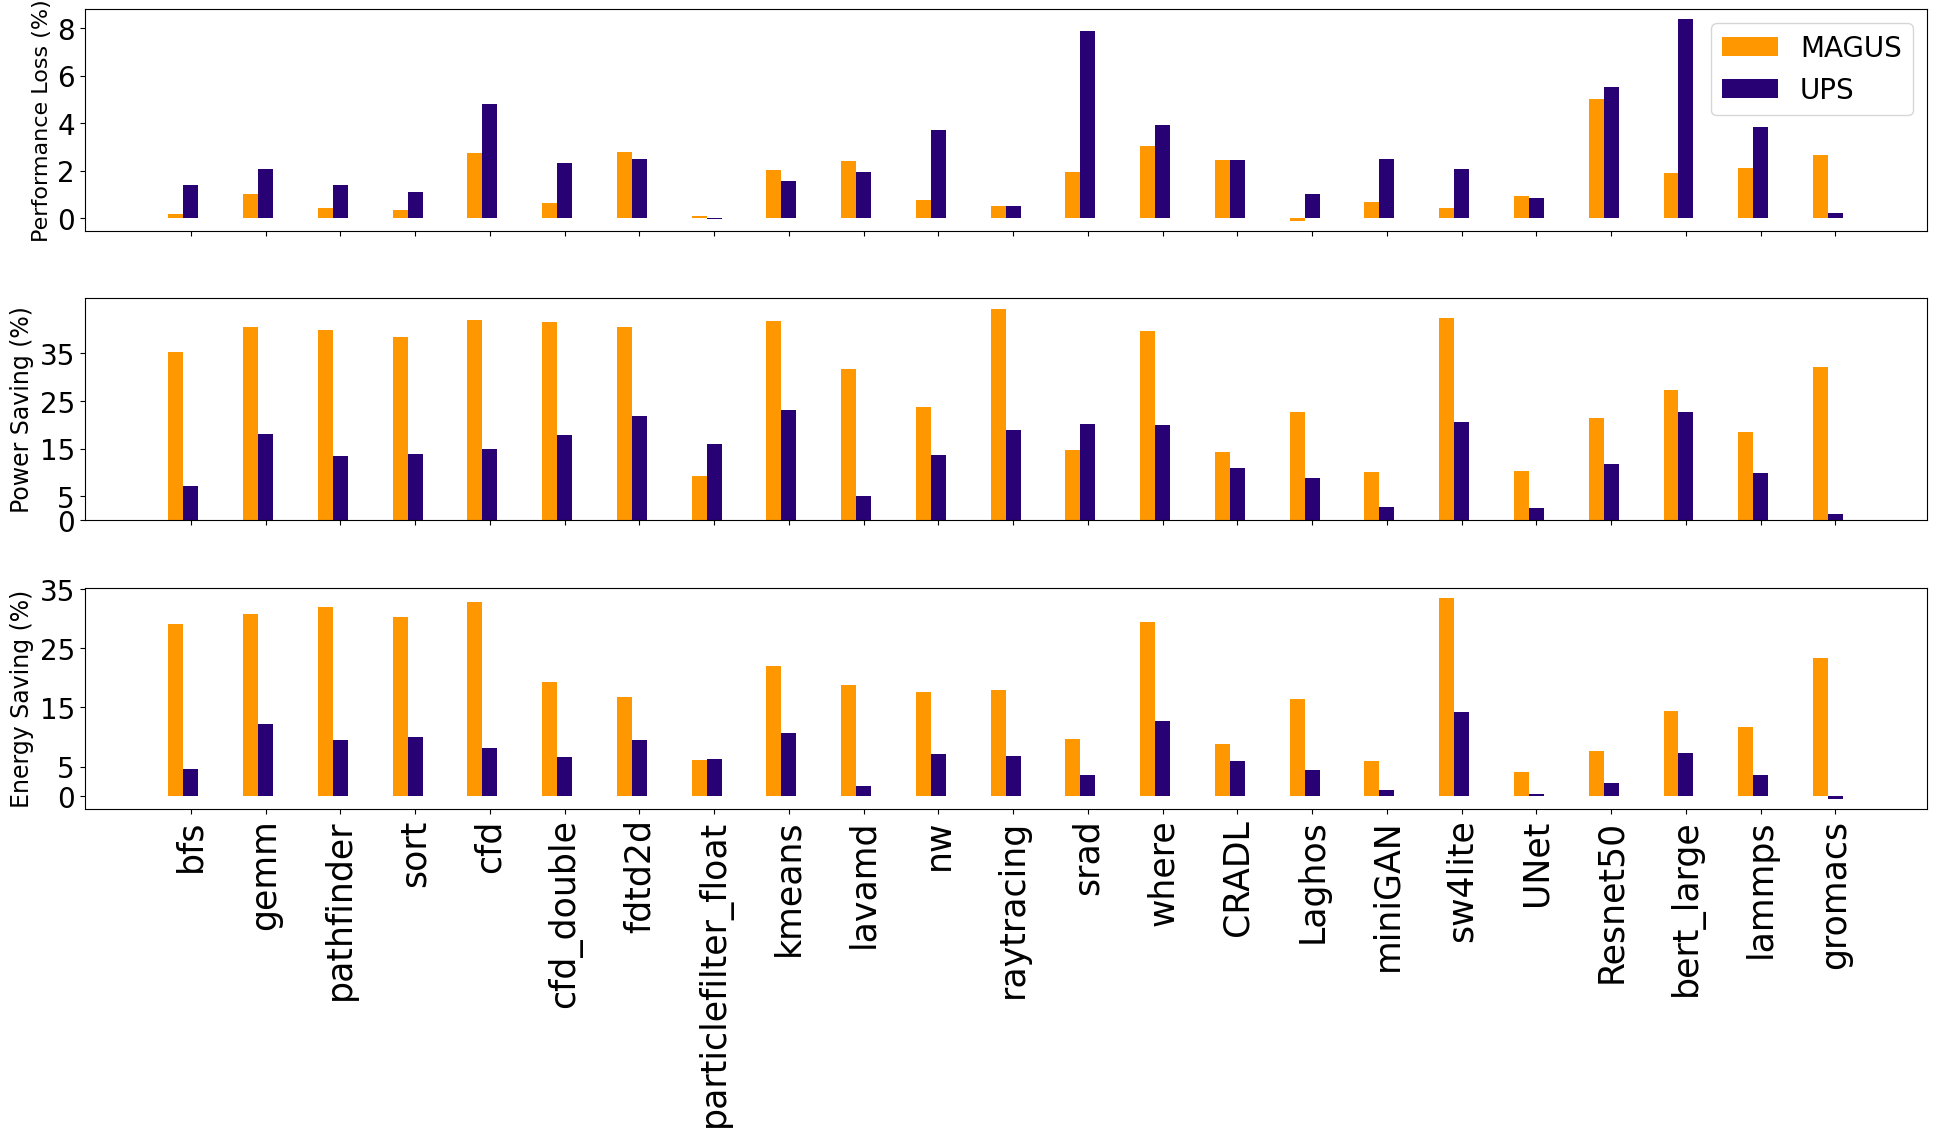

In [38]:
benchmarks1 = [
     "bfs", "gemm", 
    "pathfinder", "sort", "cfd", "cfd_double", "fdtd2d","particlefilter_float", "kmeans", "lavamd", 
    "nw", "raytracing", "srad", "where"
]
benchmarks2 = ['CRADL', 'Laghos', 'miniGAN', 'sw4lite','UNet','Resnet50','bert_large','lammps','gromacs']

# Directories
baseline_dir = "/no_power_shift/max_uncore/"
min_uncore_dir = "/no_power_shift/min_uncore/"
dynamic_uncore_dir = "/no_power_shift/dynamic_uncore/"
ups_uncore_dir = "/no_power_shift/ups_uncore/"


runtimes_loss, energy_savings, edp_savings,ed2p_savings, power_savings = calculate_savings_percentage([benchmarks1,benchmarks2], 
                                                baseline_dir, min_uncore_dir, dynamic_uncore_dir, ups_uncore_dir)
# Plot combined runtime and energy savings
plot_combined_bars_savings(runtimes_loss, energy_savings, edp_savings,ed2p_savings, power_savings, benchmarks1+benchmarks2, ['Min Uncore Freq', 'MAGUS', 'UPS'],"ALTIS_ECP_saving")